In [378]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, MultiLabelBinarizer

In [379]:
df_test = pd.read_csv("../Data/test_gr/test.csv")
df_train = pd.read_csv("../Data/train_gr/train.csv")
df_overview = pd.read_csv("../Data/train_gr/game_overview.csv")
df_train.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


In [380]:
df_train[(df_train["title"] == "PlanetSide 2") & (df_train["user_suggestion"] == 1)]

,review_id,title,year,user_review,user_suggestion
8890,11900,PlanetSide 2,2018.0,"Planetside 2 is truly stunning,It features a m...",1
8891,11901,PlanetSide 2,2014.0,"When i first started playing this game, I thou...",1
8892,11902,PlanetSide 2,2014.0,Good for people that like to mash themselfs en...,1
8894,11904,PlanetSide 2,2014.0,Note: to see this review in its true form go t...,1
8895,11905,PlanetSide 2,2016.0,£1 per hour is considered good value yeah? Wel...,1
...,...,...,...,...,...
9356,12366,PlanetSide 2,2018.0,PROSUnique combined arms MMOFPSCompletely free...,1
9357,12367,PlanetSide 2,2018.0,"6/10Pretty good gunfights, though sometimes my...",1
9358,12368,PlanetSide 2,2014.0,This is pretty awesome. Im no full time Fps fa...,1
9359,12369,PlanetSide 2,2018.0,[I am only stating my personal opinion in this...,1


In [434]:
#group training data by title and aggregate the mean of the user_suggestion
d = df_train.groupby([df_train["title"]], as_index=False).agg({"user_suggestion": "mean"}).sort_values(by="user_suggestion", ascending=False)
d.head()


,title,user_suggestion
14,EverQuest II,0.971014
16,Fractured Space,0.958217
21,Path of Exile,0.906114
6,Creativerse,0.900407
22,PlanetSide 2,0.896186


In [435]:
#join the training and overview data into an array
df_join = [d, df_overview]
#convert array into data frame
df_join = pd.concat(df_join)

#group by title and ensure that other relevant columns are preserved. Everything else is dropped
df_join = df_join.groupby(["title"]).agg({"user_suggestion": "mean", "tags": "first"}).reset_index().sort_values(by="user_suggestion", ascending=False)
df_join.head()

,title,user_suggestion,tags
20,EverQuest II,0.971014,"Free to Play, Massively Multiplayer, RPG, MMOR..."
23,Fractured Space,0.958217,"Space, Multiplayer, Free to Play, PvP, MOBA, A..."
34,Path of Exile,0.906114,"Free to Play, Action RPG, Hack and Slash, RPG,..."
9,Creativerse,0.900407,"Free to Play, Survival, Open World, Multiplaye..."
35,PlanetSide 2,0.896186,"Free to Play, Massively Multiplayer, FPS, Shoo..."


genre = []
#iterate through tags column and concat into a single dataframe
for i, row in ov_filtered["tags"].items():
    df = row.replace("[", "").replace("]", "").replace("'", "")
    ov_filtered["tags"][i] = df
    genre = genre + df.split(", ")
df_genre = pd.DataFrame(data=genre)
#df_overview["tags"].head()
df_genre.value_counts()

#match_df = d["title"].isin(ov_filtered["title"])
d["tags"] = np.nan
for i, row in d.iterrows():
    s = row["title"]
    tag = ov_filtered.loc[ov_filtered["title"] == s]
    d["tags"][i] = tag["tags"].item()
d

In [383]:
df_final = df_join.copy(deep=True)
df_encoded = df_join.copy(deep=True)

In [384]:
le = LabelEncoder()
oe = OrdinalEncoder().set_output(transform="pandas")
df_encoded["title"] = le.fit_transform(df_encoded["title"])
df_encoded.head()

,title,user_suggestion,tags
20,20,0.971014,"['Free to Play', 'Massively Multiplayer', 'RPG..."
23,23,0.958217,"['Space', 'Multiplayer', 'Free to Play', 'PvP'..."
34,34,0.906114,"['Free to Play', 'Action RPG', 'Hack and Slash..."
9,9,0.900407,"['Free to Play', 'Survival', 'Open World', 'Mu..."
35,35,0.896186,"['Free to Play', 'Massively Multiplayer', 'FPS..."


In [394]:
genre = []
#iterate through tags column and concat into a single dataframe
for i, row in df_overview["tags"].items():
    df = row.replace("[", "").replace("]", "").replace("'", "")
    df_overview["tags"][i] = df
    genre = genre + df.split(", ")
df_genre = pd.DataFrame(data=genre)
df_genre.value_counts()

Free to Play             63
Multiplayer              61
Action                   54
Massively Multiplayer    48
Co-op                    42
                         ..
City Builder              1
Side Scroller             1
Cartoony                  1
Cartoon                   1
Real-Time                 1
Name: count, Length: 161, dtype: int64

In [440]:
#keep the first 5 tags and filter out the rest
df_join[~(df_join["user_suggestion"] == 0) & ~(df_join["user_suggestion"] == 1)]
df_join

,title,user_suggestion,tags
20,EverQuest II,0.971014,"Free to Play, Massively Multiplayer, RPG, MMOR..."
23,Fractured Space,0.958217,"Space, Multiplayer, Free to Play, PvP, MOBA, A..."
34,Path of Exile,0.906114,"Free to Play, Action RPG, Hack and Slash, RPG,..."
9,Creativerse,0.900407,"Free to Play, Survival, Open World, Multiplaye..."
35,PlanetSide 2,0.896186,"Free to Play, Massively Multiplayer, FPS, Shoo..."
...,...,...,...
49,Star Trek Online,NaN,"Free to Play, Sci-fi, Massively Multiplayer, S..."
53,The Lord of the Rings Online™,NaN,"Free to Play, MMORPG, Massively Multiplayer, R..."
54,Tree of Savior (English Ver.),NaN,"MMORPG, Massively Multiplayer, Free to Play, R..."
56,VEGA Conflict,NaN,"Free to Play, Space, Strategy, Massively Multi..."


<Axes: xlabel='title', ylabel='user_suggestion'>

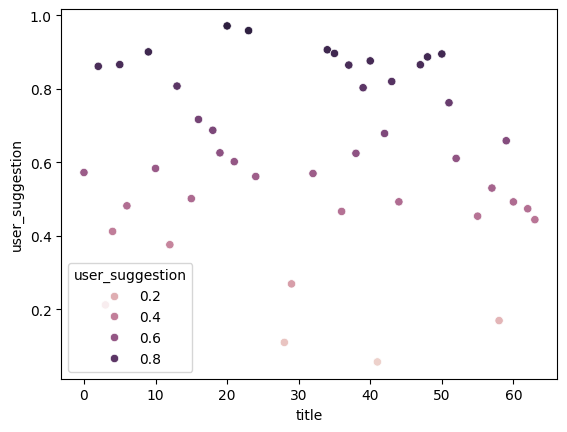

In [392]:
sns.scatterplot(
    data=df_encoded, x="title", y="user_suggestion", hue="user_suggestion"
)

In [386]:
sample_fps = df_encoded[df_encoded["tags"].str.contains("FPS", case=False)]
sample_co = df_encoded[df_encoded["tags"].str.contains("Co-op", case=False)]
sample_horror = df_encoded[df_encoded["tags"].str.contains("Horror", case=False)]

In [402]:
df_encoded[df_encoded["tags"].str.contains("Multiplayer", case=False) & df_encoded["tags"].str.contains("Free to Play", case=False) & df_encoded["tags"].str.contains("Action", case=False)]

,title,user_suggestion,tags
20,20,0.971014,"['Free to Play', 'Massively Multiplayer', 'RPG..."
23,23,0.958217,"['Space', 'Multiplayer', 'Free to Play', 'PvP'..."
34,34,0.906114,"['Free to Play', 'Action RPG', 'Hack and Slash..."
9,9,0.900407,"['Free to Play', 'Survival', 'Open World', 'Mu..."
35,35,0.896186,"['Free to Play', 'Massively Multiplayer', 'FPS..."
50,50,0.894737,"['Free to Play', 'Strategy', 'Multiplayer', 'T..."
48,48,0.886740,"['Horror', 'Free to Play', 'Cute', 'First-Pers..."
40,40,0.875895,"['Early Access', 'Free to Play', 'Battle Royal..."
5,5,0.865854,"['Free to Play', 'Multiplayer', 'Fighting', '2..."
2,2,0.861111,"['Early Access', 'Free to Play', 'FPS', 'Multi..."


In [408]:
df_encoded["user_suggestion"].tail()

49   NaN
53   NaN
54   NaN
56   NaN
61   NaN
Name: user_suggestion, dtype: float64

ValueError: cannot reindex on an axis with duplicate labels

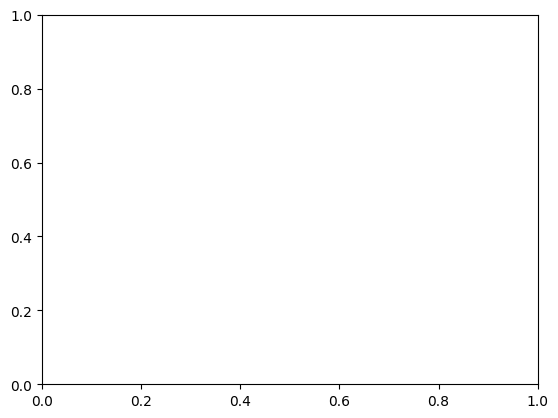

In [398]:
sns.scatterplot(data=top_3, x="title", y="user_suggestion", hue="title")

In [388]:
fps = df_final[df_final["tags"].str.contains("FPS", case=False)]
sample_co = df_final[df_final["tags"].str.contains("Co-op", case=False)]
sample_horror = df_final[df_final["tags"].str.contains("Horror", case=False)]
df_final.head()

,title,user_suggestion,tags
20,EverQuest II,0.971014,"['Free to Play', 'Massively Multiplayer', 'RPG..."
23,Fractured Space,0.958217,"['Space', 'Multiplayer', 'Free to Play', 'PvP'..."
34,Path of Exile,0.906114,"['Free to Play', 'Action RPG', 'Hack and Slash..."
9,Creativerse,0.900407,"['Free to Play', 'Survival', 'Open World', 'Mu..."
35,PlanetSide 2,0.896186,"['Free to Play', 'Massively Multiplayer', 'FPS..."


<Axes: xlabel='title', ylabel='user_suggestion'>

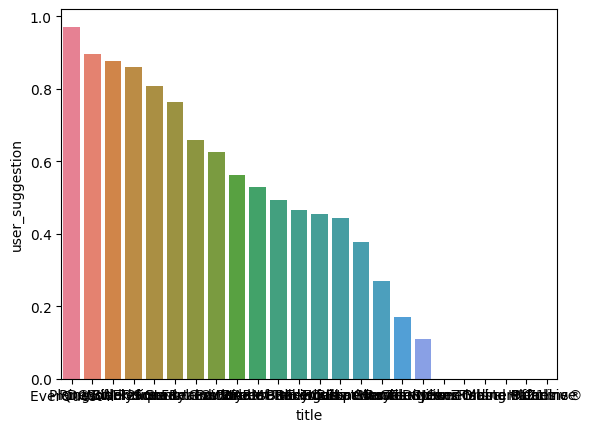

In [389]:
sns.barplot(data=fps, x="title", y="user_suggestion", hue="title")

In [391]:
#tags = {}
#for i, row in df_encoded.iterrows():
    #tags[row["title"][i]] = 